<a href="https://colab.research.google.com/github/dpk-a7/Deep-learning/blob/main/toxic_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
# !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-07-09 16:26:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-09 16:26:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-09 16:26:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json# For competition datasets
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

     |████████████████████████████████| 81kB 2.7MB/s 
     |████████████████████████████████| 4.2MB 5.1MB/s 
     |████████████████████████████████| 143kB 27.2MB/s 
     |████████████████████████████████| 112kB 28.6MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ho15b_68/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ho15b_68/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-oxb7r8ck/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"deepakavudiappan","key":"f85a7e006b065d4a782c1ab2b3ff214e"}chmod: cannot access '/root/

In [13]:
!unzip glove.6B.zip
# !unzip train.csv.zip
# !unzip test.csv.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [14]:
from __future__ import print_function, division
from builtins import range

In [15]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer # individual component in a sentence like(words,punctuation)
from keras.preprocessing.sequence import pad_sequences # normalize length
from keras.layers import Dense, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPool1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score # area under curve matric which is useful for binary classification

In [16]:
MAX_SEQ_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [17]:
#loading word vectors..
word2vec = {} #key = word: value = vectors
with open(os.path.join("glove.6B.%sd.txt" % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype= 'float32')
    word2vec[word] = vec
print("found %s word vectors" % len(word2vec))

found 400000 word vectors


In [18]:
word2vec['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [19]:
#Loading comments
train = pd.read_csv("train.csv")
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [20]:
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ['toxic', 'severe_toxic', 'obscene',
                   'threat','insult', 'identity_hate']
targets = train[possible_labels].values

In [21]:
print("max sequence length:",max(len(s)for s in sentences))
print("min sequence length:",min(len(s)for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s)//2]) 

max sequence length: 5000
min sequence length: 6
median sequence length: 205


In [22]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [23]:
word2idx = tokenizer.word_index
print("found %s unique tokens" % len(word2idx))

found 210337 unique tokens


In [24]:
data = pad_sequences(sequences, maxlen = MAX_SEQ_LENGTH)
print("Shape of data tensor:", data.shape)

Shape of data tensor: (159571, 100)


In [25]:
print("Filling pre-trained embeddings..")
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings..


In [26]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQ_LENGTH,
    trainable = False
)

In [27]:
input_ = Input(shape=(MAX_SEQ_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation = 'relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [28]:
history = model.fit(
    data,
    targets,
    batch_size = BATCH_SIZE,
    epochs= EPOCHS,
    validation_split= VALIDATION_SPLIT
)

Epoch 1/10
998/998 [==============================] - 127s 111ms/step - loss: 0.1052 - accuracy: 0.9360 - val_loss: 0.0705 - val_accuracy: 0.9509
Epoch 2/10
998/998 [==============================] - 111s 111ms/step - loss: 0.0672 - accuracy: 0.9928 - val_loss: 0.0716 - val_accuracy: 0.9939
Epoch 3/10
998/998 [==============================] - 110s 110ms/step - loss: 0.0633 - accuracy: 0.9933 - val_loss: 0.0680 - val_accuracy: 0.9928
Epoch 4/10
998/998 [==============================] - 110s 111ms/step - loss: 0.0612 - accuracy: 0.9931 - val_loss: 0.0710 - val_accuracy: 0.9941
Epoch 5/10
998/998 [==============================] - 111s 111ms/step - loss: 0.0584 - accuracy: 0.9932 - val_loss: 0.0836 - val_accuracy: 0.9930
Epoch 6/10
998/998 [==============================] - 110s 110ms/step - loss: 0.0549 - accuracy: 0.9939 - val_loss: 0.0799 - val_accuracy: 0.9930
Epoch 7/10
998/998 [==============================] - 109s 110ms/step - loss: 0.0534 - accuracy: 0.9936 - val_loss: 0.0835 -

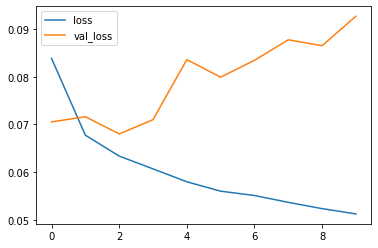

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

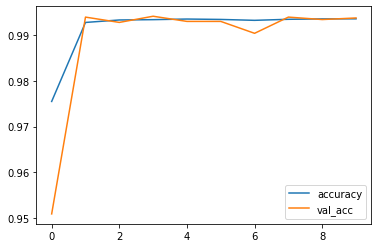

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show();

In [31]:
p = model.predict(data)
aucs = []
del i
for i in range(5):
  auc = roc_auc_score(targets[:,i], p[:,i])
  aucs.append(auc)
print(np.mean(aucs))

0.9718710715825385


In [71]:
def single_predict(sentence):
  single_sequences = tokenizer.texts_to_sequences(sentence)
  pad_input=[[j for i in single_sequences for j in i]]
  single_data = pad_sequences(pad_input, maxlen=MAX_SEQ_LENGTH)
  
  p = model.predict(single_data)
  p = list(p)
  
  print(ans)
  print(p)
  for i in p[0]:
    print(max([i]))
  print('->',max(p[0]))
single_predict("very bad")

toxic
[array([2.6075065e-02, 5.9760600e-06, 6.6613555e-03, 1.2003346e-05,
       5.0244629e-03, 4.1005015e-04], dtype=float32)]
0.026075065
5.97606e-06
0.0066613555
1.2003346e-05
0.005024463
0.00041005015
-> 0.026075065


In [88]:
def single_predict(sentence):
    single_sequences = tokenizer.texts_to_sequences(sentence)
    single_data = pad_sequences(single_sequences, maxlen=MAX_SEQ_LENGTH)
    p = model.predict(single_data)[-1]
    lab = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    p = [i for i in p]
    ans = lab[p.index(max(p))] if max(p) > 0.057 else "Neutral"
    print(ans)
    print(p)
single_predict("youll die")

toxic
[0.12318897, 0.0014285147, 0.06058517, 0.00016668439, 0.051748753, 0.0039297044]
